# Spotify Top 50 Songs Analysis
### Riley Lankshear

### Questions:
* What genres are most common?
* What are the most influential features?
* Are there recurring artists? --> If so, are there commonalities between songs other than the artists name?
* What do the other features look like? (Energy, danceability, loudness etc...)
* Does popularity imply ordinal ranking of songs?
* Can we predict whether a song will be in the top 10? 



In [146]:
# Importing necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Regression imports
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import logit
from sklearn.metrics import classification_report, accuracy_score


## Exploratory Data Analysis (EDA)

In [147]:
# Importing data into local dataframe
filename="/Users/Riley/Desktop/Me/Who?/2020_Summer/Data Sets/top50.csv"
# Imported 2018 data for training purposes incase of applicable regression analysis
filename1="/Users/Riley/Desktop/Me/Who?/2020_Summer/Data Sets/top2018.csv"

df=pd.read_csv(filename,encoding='ISO-8859-1')
df_2018=pd.read_csv(filename1,encoding='ISO-8859-1')

display(df.head())

print("Dimensions of dataframe: ",df.shape)

,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


Dimensions of dataframe:  (50, 14)


In [148]:
# Deleting first Unnamed column --> no applicability 
del df['Unnamed: 0']

# Renaming the columns
df.rename(columns={'Track.Name':'track_name','Artist.Name':'artist_name','Beats.Per.Minute':'beats_per_minute','Loudness..dB..':'loudness','Valence.':'valence','Length.':'length', 'Acousticness..':'acousticness','Speechiness.':'speechiness','Genre':'genre','Energy':'energy','Danceability':'danceability','Liveness':'liveness','Popularity':'popularity'},inplace=True)

# Checking rename was successful
df.head(0)

,track_name,artist_name,genre,beats_per_minute,energy,danceability,loudness,liveness,valence,length,acousticness,speechiness,popularity


In [149]:
# Check to see if there is any missing data
df.isnull().sum()

track_name          0
artist_name         0
genre               0
beats_per_minute    0
energy              0
danceability        0
loudness            0
liveness            0
valence             0
length              0
acousticness        0
speechiness         0
popularity          0
dtype: int64

#### Looking to see what genres of music dominate the top 50 songs

In [150]:
labels = df['genre'].value_counts().index
values = df['genre'].value_counts().values

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

genre_index = df['genre'].value_counts().index
genre_values = df['genre'].value_counts().values

print("5 most common genres are: \n")
for i in range(0,5):
    print(" Genre: ", genre_index[i], " --- Frequency: ", genre_values[i], " --- as a percentage: ", (genre_values[i]/len(df['genre'])))

fragmented_sum = 0
for i in range(3,len(genre_index)):
    fragmented_sum += genre_values[i]


print("\nAverage of the remaining 60% 'fragmented' market:")
print((fragmented_sum*2)/(len(genre_index)-3))

5 most common genres are: 

 Genre:  dance pop  --- Frequency:  8  --- as a percentage:  0.16
 Genre:  pop  --- Frequency:  7  --- as a percentage:  0.14
 Genre:  latin  --- Frequency:  5  --- as a percentage:  0.1
 Genre:  edm  --- Frequency:  3  --- as a percentage:  0.06
 Genre:  canadian hip hop  --- Frequency:  3  --- as a percentage:  0.06

Average of the remaining 60% 'fragmented' market:
3.3333333333333335


* The holistic pop genre dominates the top 50 charts at approximately 42% (this encompasses all forms of 'pop' e.g. "canadian pop")
* The top three genres; dance pop, pop, and latin account for 40% of the top 50 songs
* The remaining 60% of the top 50 songs are highly fragmented with an average size of 3.3% 

In [151]:
bpm_index = df['beats_per_minute'].value_counts().index
bpm_values = df['beats_per_minute'].value_counts().values

print("\nThe 5 most common bpm for songs are: ")
for i in range(0,5):
    print("BPM ", bpm_index[i], "- Frequency: ", bpm_values[i])
    
fig = px.histogram(df, x="beats_per_minute", nbins=15)
fig.show()


The 5 most common bpm for songs are: 
BPM  176 - Frequency:  5
BPM  96 - Frequency:  4
BPM  98 - Frequency:  3
BPM  93 - Frequency:  3
BPM  124 - Frequency:  2


* Odd occurence that the most frequent BPM is 176 which from personal knowledge is quite high
* This is backed by the positively skewed distribution of the top 50 BPM  showing that the BPM of most songs falls in 90-99 bucket
* The 176 BPM might be foreign dance music or harder style EDM music

In [152]:
# Checking to see what songs and artists have the 176 BPM
rslt_df = df[df['beats_per_minute'] == 176] 
rslt_df

lbls = rslt_df['genre'].value_counts().index
val = rslt_df['genre'].value_counts().values

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=lbls, values=val, hole=.3)])
fig.show()

* All the songs of the 178BPM are non North American genres 
* None are EDM/ house music

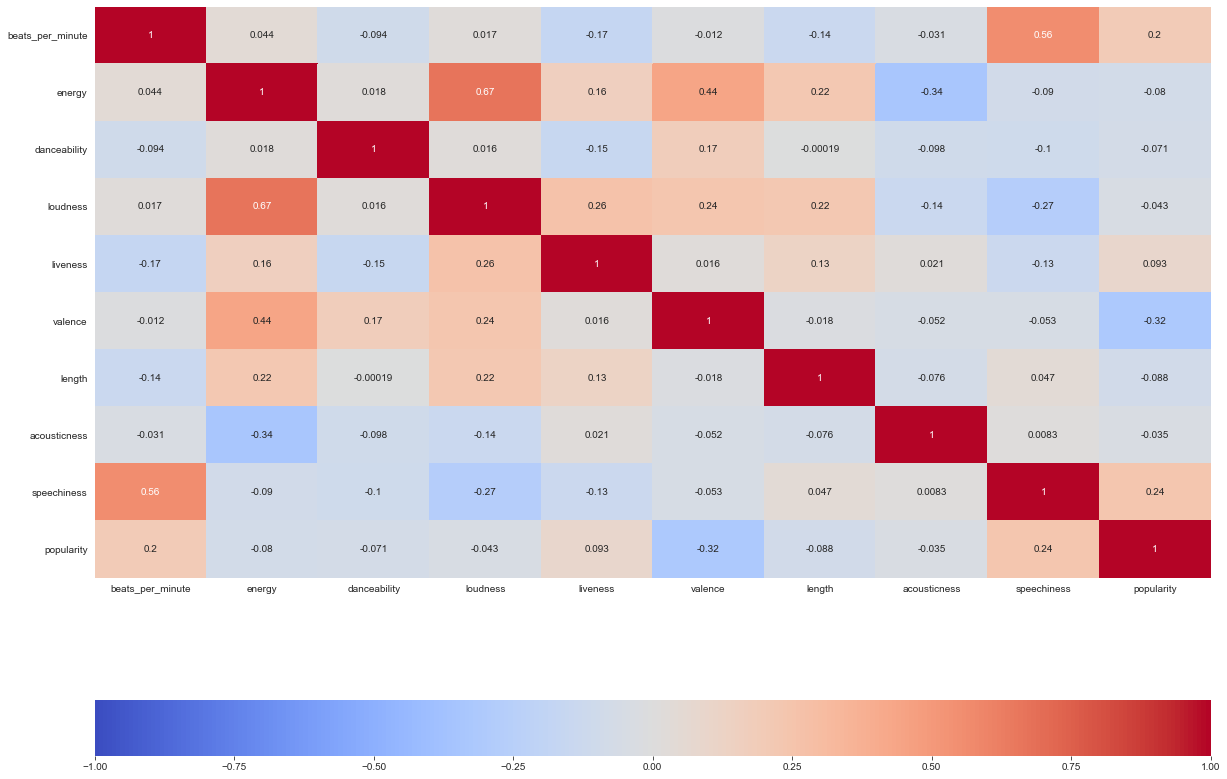

In [153]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'} )


* Energy, Loudness, and BPMs appear to be driving characteristics of top 50 songs
* The highest correlation exists between energy and loudness @0.67
* 2nd highest --> speechiness and BPMs @0.56
* 3rd highest --> energy and valence @0.44
##### Key takeaway points 
* Speechiness and BPM appear to be positive forces of a songs popularity, while valence appears to be negatively correlated to popularity
* Amongst the top 50 songs there seems to be a pattern that most have a strong relationship between; energy & loudness, BPM & speechiness, and energy & valence.
* Conversely, these songs tend to have weak relationships between; energy & accousticness, valence & popularity, and loudness & speechiness

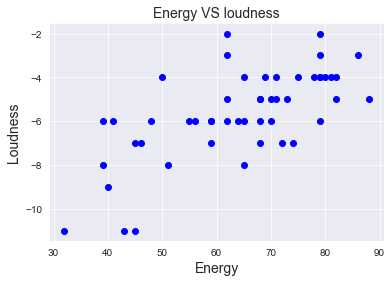

In [154]:
plt.scatter(df['energy'], df['loudness'], color='blue')
plt.title('Energy VS loudness', fontsize=14)
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Loudness', fontsize=14)
plt.grid(True)
plt.show()

* A reasonably strong linear relationship (0.63) between energy and loudness exists

#### Looking at the distributions of the dataframes quantitative features

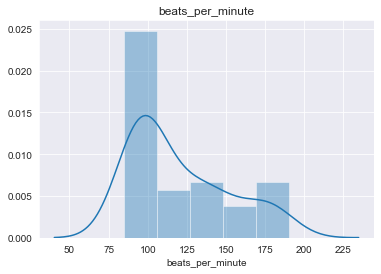

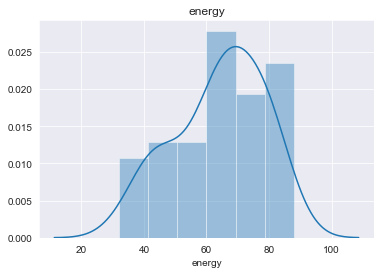

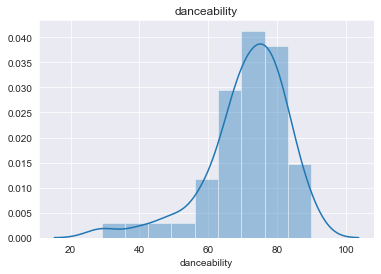

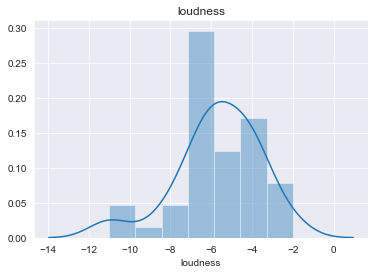

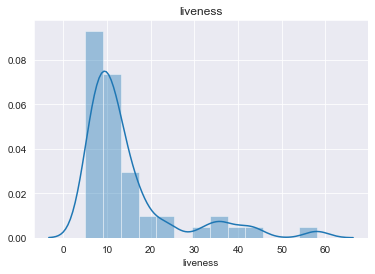

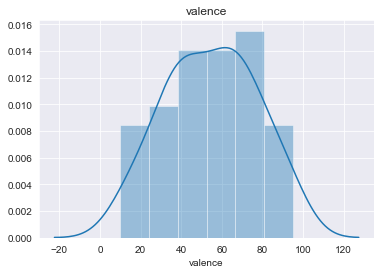

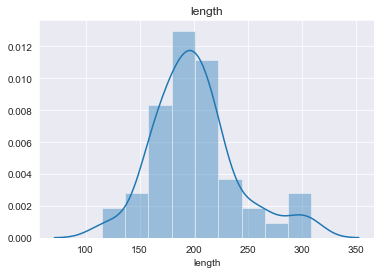

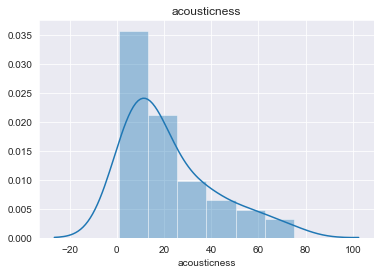

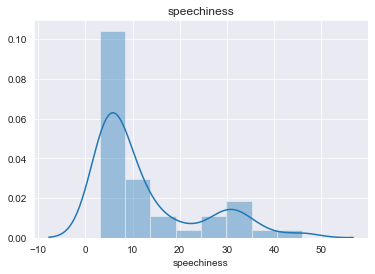

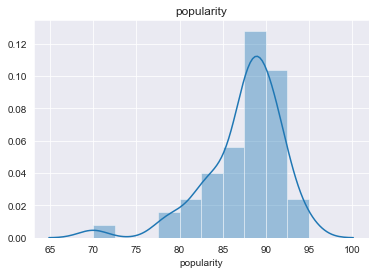

In [155]:
feature_looks = []

for i in range(3, len(df.columns)):
    feature_looks.append(df.columns[i])

for i in feature_looks:    
    plt.figure()
    plt.title(str(i))
    sns.set_style(style='darkgrid')
    sns.distplot(df[i],hist=True,kde=True)

##### BPM
* Positively skewed --> most songs exist around 90-108 BPM
* Shows most top 50 songs have lower BPMs 
##### Energy
* Slight negative skew --> a pretty normally distributed set, however with a slight negative skew showing a trailing grouping of songs between ~35-60 in energy
##### Danceability 
* Negatively skewed --> most songs have high levels of dancability
* Indicating that most top 50 songs are catered to be danceable
##### Loudness
* Slight negative skew --> most songs are pretty high with regard to loudness with a trailing set of softer songs
##### Liveness
* Positively skewed --> Majority of songs are lower in liveness values 
* Top 50 songs are typically not high in liveness
##### Valence
* Normally distributed --> Valence appears to be most normally distributed 
##### Length
* Slight positive skew --> pretty normally distributed but with a slight positive skew 
* Most top 50 songs are around 150-225 seconds long 3-4 minutes approximately (makes sense as long songs are generally not adopted by mainstream listeners, nor is too short of a song)
##### Acousticness
* Positively skewed --> most songs are ery little acoustics 
##### Speechiness
* Slight bimodal distribution --> see that most songs have little speechiness at around 5-15 with another smaller inflection point at 25-35

### Further visualization of quantitative features

In [156]:
for i in range(3, len(df.columns)-1):
    fig = px.box(df, y=df.columns[i], points="all")
    fig.show()

## Can we predict whether a song will be in the top 20?
* We will start by adding a binary column to indicate whether a song is in the top 20 of Spotify's top 50 songs 

In [243]:
df_reg = df
df_reg['top20'] = 0
for i in range(0,20):
    df_reg.top20[i] = 1
    df_reg.iloc[i, df_reg.columns.get_loc('top20')] = 1
df_reg.head(12)

/Users/Riley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,track_name,artist_name,genre,beats_per_minute,energy,danceability,loudness,liveness,valence,length,acousticness,speechiness,popularity,top10,top20
0,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79,1,1
1,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92,1,1
2,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85,1,1
3,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86,1,1
4,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94,1,1
5,I Don't Care (with Justin Bieber),Ed Sheeran,pop,102,68,80,-5,9,84,220,9,4,84,1,1
6,Ransom,Lil Tecca,trap music,180,64,75,-6,7,23,131,2,29,92,1,1
7,How Do You Sleep?,Sam Smith,pop,111,68,48,-5,8,35,202,15,9,90,1,1
8,Old Town Road - Remix,Lil Nas X,country rap,136,62,88,-6,11,64,157,5,10,87,1,1
9,bad guy,Billie Eilish,electropop,135,43,70,-11,10,56,194,33,38,95,1,1


#### Checking to see if  linear or any other form of relationship exists for regression analysis

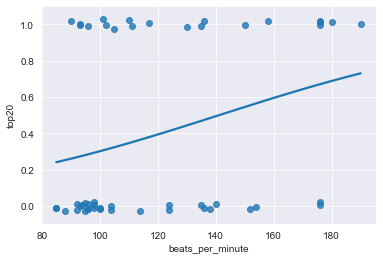

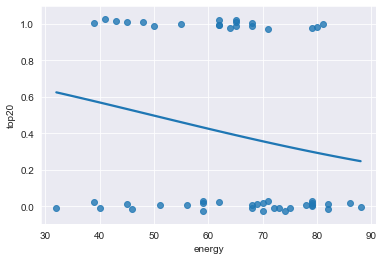

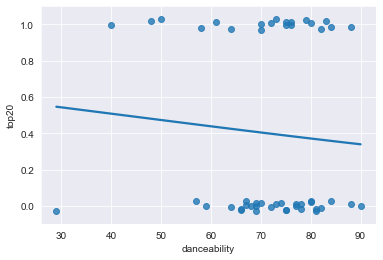

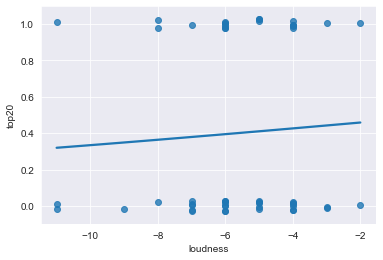

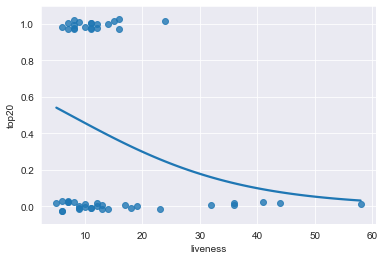

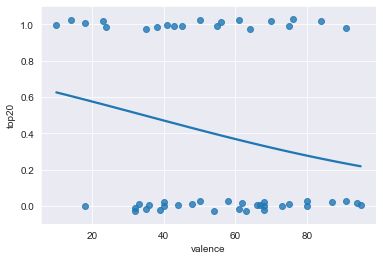

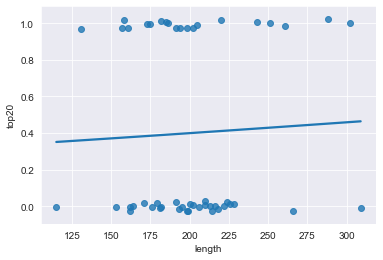

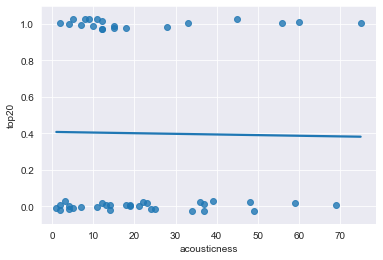

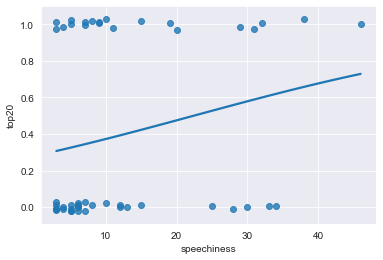

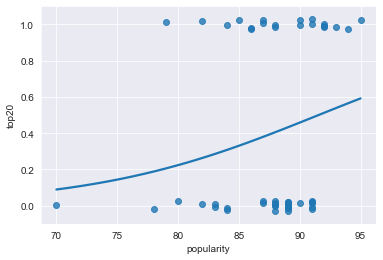

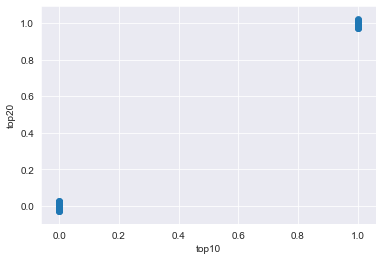

In [244]:
relationship_check = df_reg.columns

for i in range(3,len(relationship_check)-1):
    sns.regplot(x=str(relationship_check[i]), y = 'top20',
               y_jitter = 0.03,
               data = df_reg,
               logistic = True,
               ci = None)
    plt.show()
    


### Beginning Regression 

In [269]:
# Splitting the data
train_data, test_data = train_test_split(df_reg, 
                                        test_size = 0.2,
                                        random_state =42)

In [270]:
# Building the model
formula = ('top20 ~ beats_per_minute + danceability + loudness + liveness + valence + length + acousticness + speechiness + popularity')
model = logit(formula = formula, data = train_data).fit()

Optimization terminated successfully.
         Current function value: 0.550736
         Iterations 7


In [263]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  top20   No. Observations:                   40
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            9
Date:                Tue, 14 Apr 2020   Pseudo R-squ.:                  0.1923
Time:                        22:16:43   Log-Likelihood:                -22.029
converged:                       True   LL-Null:                       -27.274
Covariance Type:            nonrobust   LLR p-value:                    0.3123
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.0706     12.565      0.961      0.337     -12.556      36.697
beats_per_minute     0.0053      0.017      0.312      0.755      -0.028       0.038
danceability        -0.0355      0.040     -0.880      0.379      -0.115       0.044
loudness             0.2545      0.226      1.124      0.261      -0.189       0.698
liveness            -0.0924      0.072     -1.292      0.196      -0.233       0.048
valence             -0.0368      0.020     -1.850      0.064      -0.076       0.002
length               0.0015      0.011      0.141      0.888      -0.019       0.022
acousticness        -0.0006      0.023     -0.026      0.979      -0.046       0.045
speechiness          0.0496      0.051      0.969      0.333      -0.051       0.150
popularity          -0.0775      0.118     -0.658      0.511      -0.308       0.153
====================================================================================
"""

* McFadden Pseudo R-squared value = 0.3226 indicating a well-fitted model
* BPM, danceability, and acousticness have strong influence on whether a song is to be top 20 or not --> via p-value analysis

In [264]:
print(np.exp(model.params))

Intercept           174663.075572
beats_per_minute         1.005298
danceability             0.965077
loudness                 1.289778
liveness                 0.911779
valence                  0.963906
length                   1.001495
acousticness             0.999385
speechiness              1.050816
popularity               0.925447
dtype: float64


#### Marginal Effects Computation
* describes the impact of a predictor on the outcome variable 
* The change in outcome as a function of the change in a independent variable of interest, holding all other variables constant 
* Average Marginal Effects (AME) --> at every observed value of x and average across the results 

In [265]:
AME = model.get_margeff(at='overall',method='dydx')
print(AME.summary())

        Logit Marginal Effects       
Dep. Variable:                  top20
Method:                          dydx
At:                           overall
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
beats_per_minute     0.0010      0.003      0.314      0.754      -0.005       0.007
danceability        -0.0067      0.007     -0.910      0.363      -0.021       0.008
loudness             0.0477      0.040      1.195      0.232      -0.031       0.126
liveness            -0.0173      0.013     -1.380      0.168      -0.042       0.007
valence             -0.0069      0.003     -2.223      0.026      -0.013      -0.001
length               0.0003      0.002      0.141      0.888      -0.004       0.004
acousticness        -0.0001      0.004     -0.026      0.979      -0.009       0.008
speechiness          0.0093      0.009      1.013      0.311      -0.009       0.02

In [266]:

prediction = model.predict(exog = test_data)

cutoff=0.5

y_prediction = np.where(prediction > cutoff,1,0)

y_actual = test_data['top20']

conf_matrix = pd.crosstab(y_actual, y_prediction,
                         rownames = ["Actual"],
                         colnames = ["Predicted"],
                         margins = True)

print(conf_matrix)

Predicted  0  1  All
Actual              
0          6  1    7
1          1  2    3
All        7  3   10


In [267]:
accuracy = accuracy_score(y_actual, y_prediction)

print("Accuracy: %.2f" % accuracy + "%")

Accuracy: 0.80%


In [268]:
check = test_data
check['y_prime'] = y_prediction
check

/Users/Riley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,track_name,artist_name,genre,beats_per_minute,energy,danceability,loudness,liveness,valence,length,acousticness,speechiness,popularity,top10,top20,y_prime
13,Otro Trago - Remix,Sech,panamanian pop,176,79,73,-2,6,76,288,7,20,87,1,1,1
39,"fuck, i'm lonely (with Anne-Marie) - from 13 ...",Lauv,dance pop,95,56,81,-6,6,68,199,48,7,78,0,0,0
30,Takeaway,The Chainsmokers,edm,85,51,29,-8,10,36,210,12,4,84,0,0,1
45,One Thing Right,Marshmello,brostep,88,62,66,-2,58,44,182,7,5,88,0,0,0
17,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,dfw rap,90,48,76,-6,7,91,158,56,5,91,1,1,0
48,Call You Mine,The Chainsmokers,edm,104,70,59,-6,41,50,218,23,3,88,0,0,0
26,Dance Monkey,Tones and I,australian pop,98,59,82,-6,18,54,210,69,10,83,0,0,0
25,If I Can't Have You,Shawn Mendes,canadian pop,124,82,69,-4,13,87,191,49,6,70,0,0,0
32,0.958333333333333,Maluma,reggaeton,96,71,78,-5,9,68,176,22,28,89,0,0,0
19,Truth Hurts,Lizzo,escape room,158,62,72,-3,12,41,173,11,11,91,1,1,1
